In [ ]:
# TODO
# First get something close to fig. 1b
# Then make some have wrong opt

In [97]:
import numpy as np
import random

# Given file, get ABC lookup table
### Get list of s with corresponding summary statistics ###
def GetABCList(abcFile, num_bins):
    abc_file = open(abcFile, 'r')
    header = abc_file.readline().strip().split('\t')
    
    abc_list = []
    
    if num_bins == 0:
        for line in abc_file:
            info = line.strip().split('\t')
            s = float(info[0])
            het = float(info[1])
            common = int(info[2])
            stats_list = [s, het, common]
            abc_list.append(stats_list)
     
    # Get bins summary statistic
    else:
        # Get column number of freqs column in file
        freqs_column = 0
        for i in range(0, len(header)):
            if header[i] == 'freqs':
                freqs_column = i

        for line in abc_file:
            info = line.strip().split('\t')
            s = float(info[0])
            freq_string = info[freqs_column]
            allele_freqs = [float(freq) for freq in freq_string.split(',')]

            abc_het = 1-sum([item**2 for item in allele_freqs])
            abc_common = len([i for i in allele_freqs if i >= 0.05]) 
            abc_bins = GetBins(allele_freqs, num_bins)

            stats_list = [s, abc_het, abc_common, abc_bins]
            abc_list.append(stats_list)
        
    abc_file.close()
    return abc_list
    
def getABCTable(file):
    num_bins = 0
    
    # Return list of lists that contain [s, het, common]
    table = GetABCList(file, num_bins)
    dic_summ_stats = {}
        
    # Fill in dic_summ_stats: Key is s, value is list of het, number of common alleles pairs for given s value
    for combo in table:
        s_round = get_LRT_bin(combo[0])
        if s_round not in dic_summ_stats:
            dic_summ_stats[s_round] = []
        dic_summ_stats[s_round].append([combo[1], combo[2]]) # Append het, number of common alleles for s value
    
    return dic_summ_stats

# Get LRT bin for given s
def get_LRT_bin(s):
    if s < 0.00001:
        return 0
    if s <= 0.0001:
        return round(s, 5)
    if s <= 0.001:
        return round(s, 4)
    if s <= 0.01:
        return round(s, 3)
    if s <= 0.1:
        return round(s,2)
    return round(s,1)

# Function to get distribution of simulated heterozygosity and number of common alleles
def GetLists(ABC_tables, opt_allele_list, a, b):
    
    het_list = []
    common_list = []
    
    for combo in opt_allele_list:
        
        if a == 2:
            s = 0
        else:
            s = np.random.gamma(a, b)
            if s > 1:
                s = 1
        
        # Get heterozygosity and number of common alleles from lookup table; add summary statistics to het_list and common_list
       
        per = combo[0]
        optimal_ru = combo[1]
        if per == 3 and optimal_ru > 13:
            optimal_ru = 13
        if per == 3 and optimal_ru < 5:
            optimal_ru = 5
        if per == 4 and optimal_ru > 10:
            optimal_ru = 10
        if per == 4 and optimal_ru < 7:
            optimal_ru = 7
        if per == 2 and optimal_ru < 11:
            optimal_ru = 11
        if per == 2 and optimal_ru > 20:
            optimal_ru = 20
        
        dic_summ_stats = ABC_tables[optimal_ru] 
        s_round = get_LRT_bin(s)
        
        if s_round not in dic_summ_stats:
            s_list_available = []
            for elem in dic_summ_stats:
                s_list_available.append(elem)
            s_round = getNearestS(s_round, s_list_available)
        
        table = dic_summ_stats[s_round]
        pair = random.choice(table)
        het, common = pair[0], pair[1]
        het_list.append(het)
        common_list.append(common)
    
    return het_list, common_list
    
# Return whether to accept shape, scale pair
def EstimateParamBinAgnostic(ABC_tables, opt_allele_list, a, b, obs_het_list, obs_common_list, eps_het, eps_common, use_common, normalized=False, const=0):
    
    het_list, common_list = GetLists(ABC_tables, opt_allele_list, a, b)
    
    het_list.sort()
    obs_het_list.sort()
    
    if normalized == False:
        diff_vector = GetDiffVector(het_list, obs_het_list)
        
    else:
        diff_vector = GetDiffVector(het_list, obs_het_list, True, const)
    
    mean_of_differences = np.mean(diff_vector)
    
    to_accept = False
    
    if use_common == False:
        if mean_of_differences < eps_het:
            to_accept = True

        return to_accept, mean_of_differences, diff_vector
    
    else:
        
        if mean_of_differences < eps_het and dist_common < eps_common:
            to_accept = True
            
        return to_accept, mean_of_differences, diff_vector

# Get difference vector
def GetDiffVector(vector1, vector2, normalized = False, const = 0):
    diff_vector = []
    for i in range(0, len(vector1)):
        distance = abs(vector1[i] - vector2[i])
        if normalized == False:
            diff_vector.append(distance)
        else:
            if distance == 0:
                diff_vector.append(distance)
            else:
                mean = (vector1[i] + vector2[i])/2 + const

                diff_vector.append(distance/mean)
    return diff_vector

def SISTR2(period, opt, model, obs_het_distr, num_sims=50000, PERC_ACC=1):
    ABC_tables = {}
    if period == 2:
        ptype = "di"
    elif period == 3:
        ptype = "tri"
    elif period == 4:
        ptype = "tetra"
    else:
        return None, (None, None)
    abcfile="/Users/melissagymrek/Downloads/sistr_joint_resources/eurodem_prior2_%snuc_%s_1kg_euro/%s_%s.txt"%(ptype, model, period, opt)
    ABC_tables[opt] = getABCTable(abcfile)

    # get lists of hets, common
    opt_allele_sub_list = [(period, opt)]
    obs_common_distr = []

    eps_het = 0.1
    eps_common = 0.1
    use_common = False
    list_all_params = []
    list_all_dist = []
    sim_het_lists = []
    accepted_params = []

    for i in range(0, num_sims):
        a = np.random.uniform() 
        mu, sigma = np.log(0.0003), np.log(30)
        mean = np.random.lognormal(mu, sigma)
        b = mean/a

        to_accept, mean_of_differences, diff_vector = EstimateParamBinAgnostic(ABC_tables, opt_allele_sub_list, a, b, \
                                                                               obs_het_distr, obs_common_distr, eps_het, eps_common, use_common)

        list_all_dist.append((mean_of_differences))
        list_all_params.append((a,b))

    top_x_num = int(PERC_ACC * num_sims / 100)
    top_idx = np.argsort(list_all_dist)[:top_x_num]
    accepted_params = [list_all_params[i] for i in top_idx]

    if len(accepted_params) > 0:
        sort_mean = sorted(accepted_params, key=lambda x: x[0]*x[1])
        list_of_means = []
        for pair in sort_mean:
            list_of_means.append(pair[0]*pair[1])

        num_accepted = len(accepted_params)
        middle_index = int(num_accepted/2)

        mean_lower_bound = np.percentile(list_of_means, 2.5)
        mean_upper_bound = np.percentile(list_of_means, 97.5)
        median_mean = np.median(list_of_means)
        return median_mean, (mean_lower_bound, mean_upper_bound)

# Test - should get very high s
print(SISTR2(period=2, opt=20, model="e", obs_het_distr=[0]*1000, num_sims=1000))

# Test - should get very low s
print(SISTR2(period=2, opt=20, model="e", obs_het_distr=[0.5]*1000, num_sims=1000))

(0.6760555896422935, (0.18095315735260473, 2.2524577190146333))
(0.003689094632403799, (0.0007136859446807294, 0.07818986388218917))


Notes:

https://github.com/BonnieCSE/STRSelection/blob/master/figures-submit-round1/Figure2_Plot_Mut_Rates_SISTR_v2.ipynb

Dinuc: setting e
Trinuc: setting d
Tetranuc: setting d

In [60]:
####### simulation config #######
%pylab inline
import sistr_sims as ssims
import stdpopsim

config = {
	"periods": [2, 3, 4],
	"opt_allele_ranges": [[11, 20], [5, 13], [7, 10]],
	"demog_model": "OutOfAfrica_2T12",
	"species": "HomSap",
	"popid": "EUR",
	"log10_mut_slopes": [0.15, 0.33, 0.45],
	"rhos": [0.6, 0.9, 0.9],
	"baseline_mus": [1e-05, 3.16e-06, 1e-06],
	"baseline_mu_alleles": [6, 5, 3],
	"n_effective": 7310,
	"num_gens": 55920,
	"num_alleles": 25,
	"gamma_alpha": 0.0881,
	"gamma_beta": 0.2541,
	"abc_num_sims": 10000,
	"min_mu": 1e-8,
	"max_mu": 1e-3,
	"use_drift": True,
	"end_samp_n": 6500,
	"lrt_svals": [0.0,1e-06,1e-05,2e-05,3e-05,4e-05,5e-05,6e-05,7e-05,8e-05,9e-05,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.15,0.2,0.4,0.6,0.8,1.0],
	"lrt_num_sims": 2000
}

# Set up demographic model
if config["demog_model"] is not None:
	demog_model = stdpopsim.species.registered_species[config["species"]].get_demographic_model(config["demog_model"])
	popid = config["popid"]
	n_eff = None
else:
	demog_model = None
	popid = None
	n_eff = config["n_effective"]

def RunSim(s, period, opt_allele, model, beta, config):
    ind = config["periods"].index(period)
    rho = config["rhos"][ind]
    L = config["log10_mut_slopes"][ind]
    baseline_mu = config["baseline_mus"][ind]
    baseline_mu_allele = config["baseline_mu_alleles"][ind]
    mu_prime = ssims.GetMuPrime(baseline_mu, baseline_mu_allele, L, opt_allele,
	config["min_mu"], config["max_mu"])

    transition_matrix_transpose = ssims.GetTransitionMatrix(
        config["num_alleles"], mu_prime, beta, rho, L,
        config["min_mu"], config["max_mu"]).transpose()

    return ssims.RunSimulation(
        sval=s,
        transition_matrix_transpose=transition_matrix_transpose,
        max_iter=config["num_gens"],
        n_effective=n_eff,
        demog_model=demog_model, popid=popid,
        use_drift=config["use_drift"],
        end_samp_n=config["end_samp_n"],
        ancestral_allele=0
    )

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [62]:
###### testing
# TODO - simulate actual opt to test first. then try when inferred mode != opt
# TODO - draw s from gamma. line plots like in bonnie paper https://github.com/BonnieCSE/STRSelection/blob/master/figures-submit-round1/Figure1b_JointMethod_LineGraph.ipynb


numsim=2
hets = [GetHet(RunSim(s=10e-4, period=2, opt_allele=11, model="e", beta=0.3, config=config)["afreqs"]) for i in range(numsim)]
SISTR2(PERIOD, OPT_ALLELE, MODEL, hets)

(2.2367782572696445e-05, (9.841949909662724e-07, 0.0035945099574329303))

In [145]:
PERIOD=2
OPT_ALLELE=15
MODEL="e"

def GetHet(afreqs):
    x = 0
    for f in afreqs:
        x += f**2
    return 1-x
    
a = 0.3 # gamma param b

# Put back commented params for full run
numloci = 100 # 1000 
numtimes = 10 # 20
sistr2_numsim = 50000 # 50000
svals = [10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1]

# Keep track of results
res_median_est_s = []
res_median_est_s_wrongopt_0_2 = []
res_median_est_s_wrongopt_0_8 = []

def GetWrongOpt(OPT_ALLELE, wrong=0.5, rho=0.8):
    if random.random() < wrong:
        step = np.random.geometric(p=rho)
        if random.random() > 0.5:
            return OPT_ALLELE+step
        else: return OPT_ALLELE+step*-1
    else:
        return OPT_ALLELE # no error
    
for sval in svals:
    print("Simulating s=%.2g"%sval)
    estimated_svals = []
    estimated_svals_wrongopt_0_2 = []
    estimated_svals_wrongopt_0_8 = []
    for ns in range(numtimes):
        print("   Simnum: %s/%s"%(ns+1, numtimes))
        b = sval/a # gamma param b
        hetvals = []
        hetvals_wrongopt_0_2 = []
        hetvals_wrongopt_0_8 = []
        for nl in range(numloci):
            # Draw s from gamma
            s = np.random.gamma(a, b)
            if s > 1: s=1
            # Perform simulation to get het - correct opt
            afreqs = RunSim(s=s, period=PERIOD, opt_allele=OPT_ALLELE, model=MODEL, beta=0.3, config=config)["afreqs"]
            hetvals.append(GetHet(afreqs))
            # Perform simulation to get het - sometimes opt wrong (20%)
            wrong_opt_0_2 = GetWrongOpt(OPT_ALLELE, wrong=0.2)
            afreqs_wrongopt_0_2 = RunSim(s=s, period=PERIOD, opt_allele=wrong_opt_0_2, model=MODEL, beta=0.3, config=config)["afreqs"]
            hetvals_wrongopt_0_2.append(GetHet(afreqs_wrongopt_0_2))
            # Perform simulation to get het - sometimes opt wrong (80%)
            wrong_opt_0_8 = GetWrongOpt(OPT_ALLELE, wrong=0.8)
            afreqs_wrongopt_0_8 = RunSim(s=s, period=PERIOD, opt_allele=wrong_opt_0_8, model=MODEL, beta=0.3, config=config)["afreqs"]
            hetvals_wrongopt_0_8.append(GetHet(afreqs_wrongopt_0_8))
        sres = SISTR2(PERIOD, OPT_ALLELE, MODEL, hetvals, num_sims=sistr2_numsim)
        print("     Estimated %.2g"%sres[0])
        estimated_svals.append(sres[0])
        sres_wrongopt_0_2 = SISTR2(PERIOD, OPT_ALLELE, MODEL, hetvals_wrongopt_0_2, num_sims=sistr2_numsim)
        print("     Estimated %.2g - wrongopt 0.2"%sres_wrongopt_0_2[0])
        estimated_svals_wrongopt_0_2.append(sres_wrongopt_0_2[0])
        sres_wrongopt_0_8 = SISTR2(PERIOD, OPT_ALLELE, MODEL, hetvals_wrongopt_0_8, num_sims=sistr2_numsim)
        print("     Estimated %.2g - wrongopt 0.8"%sres_wrongopt_0_8[0])
        estimated_svals_wrongopt_0_8.append(sres_wrongopt_0_8[0])
    res_median_est_s.append(np.median(estimated_svals))
    res_median_est_s_wrongopt_0_2.append(np.median(estimated_svals_wrongopt_0_2))
    res_median_est_s_wrongopt_0_8.append(np.median(estimated_svals_wrongopt_0_8))
    print("s=%.2g, Median estimate: %.2g, wrong20=%.2g, wrong80=%.2g"%(sval, np.median(estimated_svals), np.median(estimated_svals_wrongopt_0_2), np.median(estimated_svals_wrongopt_0_8)))

Simulating s=0.0001
   Simnum: 1/5
     Estimated 0.00057
     Estimated 0.0061 - wrongopt 0.2
     Estimated 0.00025 - wrongopt 0.8
   Simnum: 2/5
     Estimated 0.00017
     Estimated 0.0018 - wrongopt 0.2
     Estimated 0.0012 - wrongopt 0.8
   Simnum: 3/5
     Estimated 0.00048
     Estimated 0.005 - wrongopt 0.2
     Estimated 0.0023 - wrongopt 0.8
   Simnum: 4/5
     Estimated 0.00036
     Estimated 0.00025 - wrongopt 0.2
     Estimated 0.00043 - wrongopt 0.8
   Simnum: 5/5
     Estimated 0.0016
     Estimated 0.00024 - wrongopt 0.2
     Estimated 0.00022 - wrongopt 0.8
s=0.0001, Median estimate: 0.00048, wrong20=0.0018, wrong80=0.00043
Simulating s=0.1
   Simnum: 1/5
     Estimated 0.071
     Estimated 0.1 - wrongopt 0.2
     Estimated 0.043 - wrongopt 0.8
   Simnum: 2/5
     Estimated 0.44
     Estimated 0.22 - wrongopt 0.2
     Estimated 0.43 - wrongopt 0.8
   Simnum: 3/5
     Estimated 0.38
     Estimated 0.22 - wrongopt 0.2
     Estimated 0.47 - wrongopt 0.8
   Simnum: 4/5
 

Text(0, 0.5, 'Median inferred s')

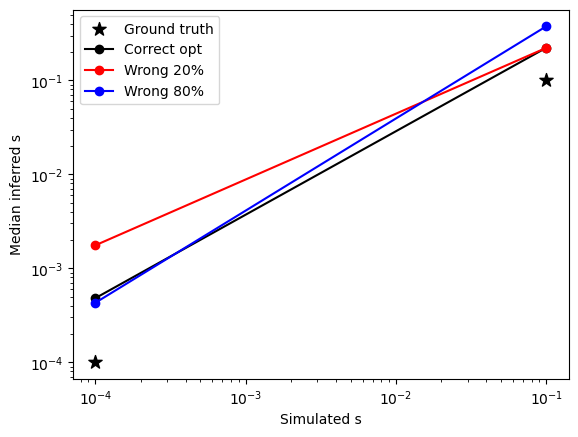

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(svals, svals, marker="*", label="Ground truth", color="black", s=100)
ax.plot(svals, res_median_est_s, color="black", marker="o", label="Correct opt")
ax.plot(svals, res_median_est_s_wrongopt_0_2, color="red", marker="o", label="Wrong 20%")
ax.plot(svals, res_median_est_s_wrongopt_0_8, color="blue", marker="o", label="Wrong 80%")
ax.set_xscale("log");
ax.set_yscale("log");
ax.legend()
ax.set_xlabel("Simulated s")
ax.set_ylabel("Median inferred s")